In [5]:
import numpy as np
from datasets import load_dataset

# Load the dataset with the `large_random_1k` subset
dataset = load_dataset('poloclub/diffusiondb', 'large_random_1k', trust_remote_code=True)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 1000 examples [00:09, 102.34 examples/s]


In [6]:
from datasets import concatenate_datasets

full_dataset = concatenate_datasets([split for split in dataset.values()])

In [7]:
# Filter the dataset to only include 'image' and 'prompt'
filtered_dataset = full_dataset.map(lambda x: {'image': x['image'], 'prompt': x['prompt']})

Map: 100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.21 examples/s]


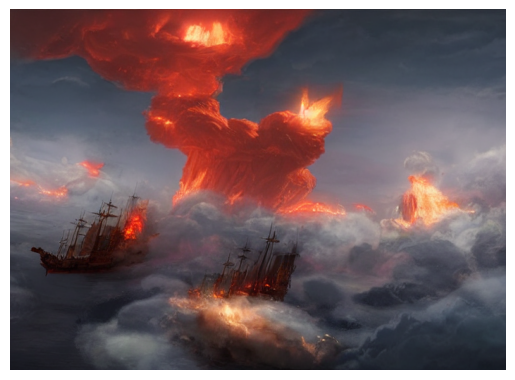

zeus [ sitting in clouds ], striking a fleet of ancient greek ships who are charging at a [ giant made of fire ], [ digital art ]!!, trending on cgsociety, artstation, polycount 


In [8]:
# Display the image and promt
import matplotlib.pyplot as plt

first_item = filtered_dataset[0]
plt.imshow(first_item['image'])
plt.axis('off')  
plt.show()

print(first_item['prompt'])

In [9]:
# Define the tokenizer and embedder model
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", revision=None)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2024-11-04 07:58:26.337319: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 07:58:27.179348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 07:58:27.179538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 07:58:27.336956: E exte

In [10]:
from PIL import Image
import torch
from torchvision import transforms

# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, transforms):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert("RGB")
        prompt = item['prompt']

        # Apply transformations to the image
        image = self.transforms(image)

        # Tokenize the prompt
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=self.tokenizer.model_max_length, padding="max_length", truncation=True)
        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        return image, input_ids, attention_mask

In [12]:
# Create the custom dataset
custom_dataset = CustomDataset(filtered_dataset, tokenizer, train_transforms)

In [13]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example[1] for example in examples])
    attention_mask = torch.stack([example[2] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [14]:
train_batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    custom_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
)

In [15]:
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler

In [16]:
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
revision = None
variant = None

noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:653: UserWarning: Not enough free disk space to download the file. The expected file size is: 3438.17 MB. The target location /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/blobs only has 2768.47 MB free disk space.
  warnings.warn(


In [17]:
# Freeze parameters of models to save more memory
mixed_precision = "fp16"
unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

# Set the weight dtype for mixed precision training
weight_dtype = torch.float16 if mixed_precision == "fp16" else torch.float32

# Move models to device and cast to weight dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

In [18]:
# Define the LoRA configuration with the new name
from peft import LoraConfig
from diffusers.training_utils import cast_training_params
unet_lora_config = LoraConfig(
    r=40,
    lora_alpha=16,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

# Add the new adapter with the unique name
unet.add_adapter(unet_lora_config)
if mixed_precision == "fp16":
    cast_training_params(unet, dtype=torch.float32)

In [19]:
import torch.nn.functional as F

In [20]:
num_train_epochs = 3
learning_rate = 1e-4

# Initialize the optimizer
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, unet.parameters()),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

# Initialize the learning rate scheduler
num_training_steps = num_train_epochs * len(dataset) // (train_batch_size)
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

In [21]:
import torch.nn.functional as F
from tqdm import tqdm

for epoch in tqdm(range(num_train_epochs), desc="Epochs"):
    unet.train()
    epoch_losses = []

    for step, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        
        # Move batch items on divice  
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype).to("cuda")
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")

        # Convert images to latent space
        latents = vae.encode(pixel_values).latent_dist.sample()
        latents = latents * vae.config.scaling_factor

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents, device=latents.device)  # Ensure noise is on the same device
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()

        # Add noise to the latents according to the noise magnitude at each timestep
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings, encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # Backpropagate
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step() 

        # Store the loss value
        epoch_losses.append(loss.item())

    # Print the average loss for the current epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch + 1}/{num_train_epochs}, Loss: {avg_loss:.4f}")

Epochs:  33%|████████████████████████▎                                                | 1/3 [01:23<02:47, 83.61s/it]

Epoch 1/3, Loss: 0.1789



Epochs:  67%|████████████████████████████████████████████████▋                        | 2/3 [02:47<01:23, 83.97s/it]

Epoch 2/3, Loss: 0.1700



Epochs: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [04:13<00:00, 84.57s/it]

Epoch 3/3, Loss: 0.1679


You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.07it/s]


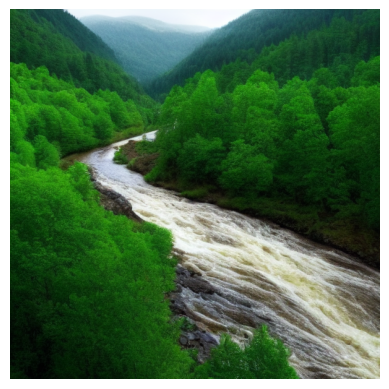

In [26]:
from diffusers import StableDiffusionPipeline

# Load the Stable Diffusion pipeline
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)

# Move the pipeline to the GPU
pipeline = pipeline.to("cuda")

prompt =  "A beautiful landscape with forest and a river"

# Generate images
with torch.autocast("cuda"):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

# Display and save the generated images
for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # Save the image
    img.save(f"generated_image_{idx}.png")